# Tutorial: Text Analytics and Explainable AI

In this tutorial, we expand on what we have learned in the text analytics part of the lecture.

This tutorial consists of the following:
1. Applying TF-IDF
2. Evaluation metrics for classification
3. Training Logistic Regression, Decision Trees and Random Forest
4. Explainable AI

Uncomment the following line to install the required libraries if you have not done so.

In [ ]:
# !pip install pandas==2.2.1 beautifulsoup4==4.12.3 scikit-learn==1.0.2 matplotlib==3.5.1 shap==0.45.0

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
from bs4 import BeautifulSoup


# Creating dataset (Optional)

This is the code to extract the posts from XML files. After processing the XML files, the posts come with HTML tags. BeautifulSoup library is used to parse the HTML tags which extracts the text of interest.

Participants are not required to know how to create the dataset, but will be good to know for web scraping.

In [34]:
datapath = [
    # ("stro", "./dataset/do_not_git/astronomy.meta.stackexchange.com/Posts.xml"),
    ("via", "./dataset/do_not_git/aviation.meta.stackexchange.com/Posts.xml"),
    ("icyc", "./dataset/do_not_git/bicycles.meta.stackexchange.com/Posts.xml"),
    ("itco", "./dataset/do_not_git/bitcoin.meta.stackexchange.com/Posts.xml"),
]

In [35]:
def html_parser(text: str, tags: list) -> str:
    """
    This function extracts the text in the given tags.
    """
    soup = BeautifulSoup(text, "html.parser")

    # Most of the important information are in <p>, <h1>, <h2> and <h3> tags
    # list_ele = soup.find_all(["p","h1", "h2", "h3", "ul", "ol"])
    list_ele = soup.find_all(tags)


    # Extract texts in these elements. Nested tags will be reduced to it's text only
    list_str = [ele.text for ele in list_ele]
    return " ".join(list_str)


In [ ]:
tags = ["p","h1", "h2", "h3", "ul", "ol"]

outdata = {
    "text": [],
    "cluster": []
}
for clusterid, dataset in enumerate(datapath):
    tree = ET.parse(dataset[1])
    root = tree.getroot()
    cnt = 0
    for child in root:
        if cnt > 5000:
            break
        else:
            cnt += 1
        
        try:
            title = child.attrib["Body"]
            # print(dataset[0] in title, title)
            if dataset[0] in title:
                # Parse the HTML tags
                title_parsed = html_parser(title, tags)
                
                outdata["text"].append(title_parsed)
                outdata["cluster"].append(clusterid)
        except Exception as e:
            # print(e)
            pass

df0 = pd.DataFrame(outdata)
df0.index.name = "id"
df0.to_csv('raw_data.csv', index=True)

# Problem Statement

We are interested to find out whether a particular StackExchange post is related to aviation or not.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [38]:
# Aviation is cluster = 0
# The folowwing returns True if cluster = 0 and False otherwise
df0["aviation"] = df0["cluster"]  == 0
# Convert to numeric representation. True = 1, False = 0 
df0["aviation"] = df0["aviation"].astype(int)

In [39]:
# Check the distribution of the positive and negative labels
df0["aviation"].value_counts()

aviation
0    1521
1    1357
Name: count, dtype: int64

In [40]:
# Get the features and the label. Lowercase the text in X
X = df0['text'].str.lower()
y = df0['aviation']

In [43]:
# Text preprocessing techniques such as stopwords removal, stemming, lemmatization may be applied before applying TF-IDF
# Perform train test split before using TF-IDF!
# Stratify on y to ensure equal distribution of 1s and 0s in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [44]:
# Vectorize the text data using TF-IDF
# Recall that we only "fit" on train set and not test set
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, stop_words='english')
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

### Evaluation of classification models

In the lecture, we went through how to measure model performance using accuracy. In this segment we will list down the other metrics that are commonly used.

Before diving into the other metrics, let's understand some of the terminology that is needed for the understanding of other metrics
1. True Positive (TP)
    - Label is **positive**, Model predicts **positive**.
2. False Positive (FP)
    - Label is **negative**, Model predicts **positive**. The positive predicted is "false"
3. False Negative (FN)
    - Label is **positive**, Model predicts **negative**. The negative predicted is "false"
4. True Negative (TN)
    - Label is **negative**, Model predicts **negative**.

Now let's dive into the metrics:

1. **Accuracy**
    - What is the proportion of data that our model predicted correctly?

    `(TP + TN) / (Number of data)`

2. **Precision** (Also known as Positive Predictive Value)
    - Out of all the positive predictions that the model made, how many are actually correct (positive) (in proportion)? 

    `(TP) / (TP + FP)`

3. **Recall** (Also known as Sensitivity)
    - Out of all the postive labels, how many of them did our model predict correctly (in proportion)?
    
    `(TP) / (TP + FN)`

4. **F1 Score**
    - The harmonic mean of Precision and Recall
    - Note that the Precision and Recall are inversely related, when one goes up, the other goes down
    - F1 score serves as a balance between these 2 metrics

    `2 * (Precision * Recall) / (Precision + Recall)`

### Which metrics to use?

It highly depends on your use case.

- If you want to balance between Precsion and Recall, use F1 Score

- If the cost of false postive (or false alarm) is higher than false negative, use **Precision**. (i.e. cost of acting is high, we want to reduce FP)
    - YouTube recommendation. We don't want to recommend videos that users don't like (FP), but it's okay to miss out some of the videos they might like (FN)

- If the cost of false negative is higher than false positive, use **Recall**. (i.e. cost of NOT acting is high, we want to reduce FN)
    - Medical diagnosis for life threatening condition (eg Heart attack). An undetected/undiagnosed life threatening condition (FN) can be fatal for the patient! 

In [59]:
def evaluate(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 score: {f1}")

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    plt.show()  

# Model 1: Logistic Regression

Accuracy: 0.9069444444444444
Precision: 0.9096385542168675
Recall: 0.8908554572271387
F1 score: 0.9001490312965722


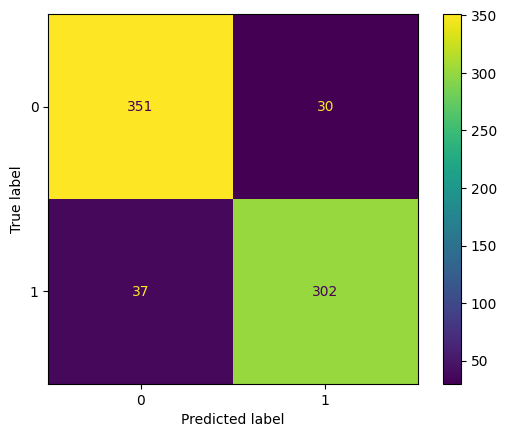

In [60]:
lr = LogisticRegression()
lr.fit(tfidf_train, y_train)

y_pred_lr = lr.predict(tfidf_test)
evaluate(y_test, y_pred_lr)

In this example:

TP = 302

FP = 30

FN = 37

TN = 351

# Model 2: Decision Trees

Accuracy: 0.8069444444444445
Precision: 0.7092050209205021
Recall: 1.0
F1 score: 0.8298653610771114


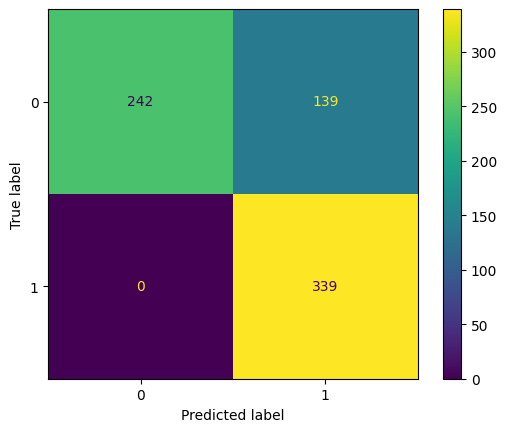

In [61]:
decision_tree = DecisionTreeClassifier(max_depth=8, random_state=42)
decision_tree.fit(tfidf_train, y_train)

y_pred_decision_tree = decision_tree.predict(tfidf_test)
evaluate(y_test, y_pred_decision_tree)

In this example:

TP = 339

FP = 139

FN = 0

TN = 242

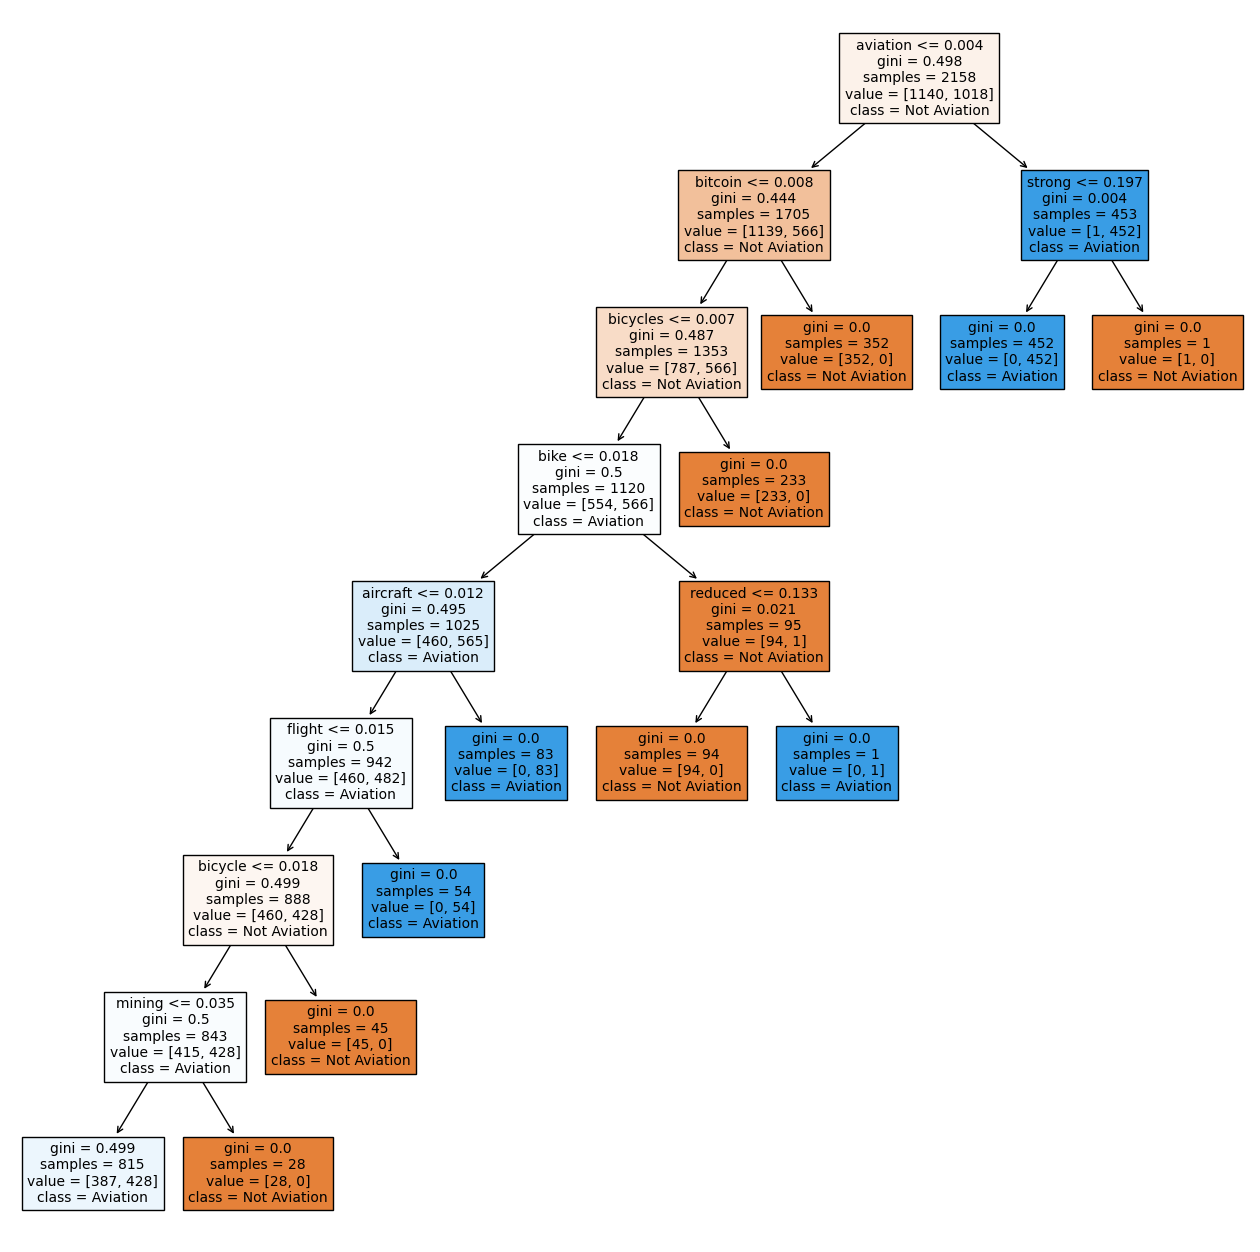

In [62]:
# Let's plot out the tree!

from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
tree.plot_tree(decision_tree, fontsize=10, filled=True, class_names=['Not Aviation', 'Aviation'], feature_names=tfidf_vectorizer.get_feature_names_out())
plt.show()

# Model 3: Random Forest

Accuracy: 0.8819444444444444
Precision: 0.9177631578947368
Recall: 0.8230088495575221
F1 score: 0.8678071539657853


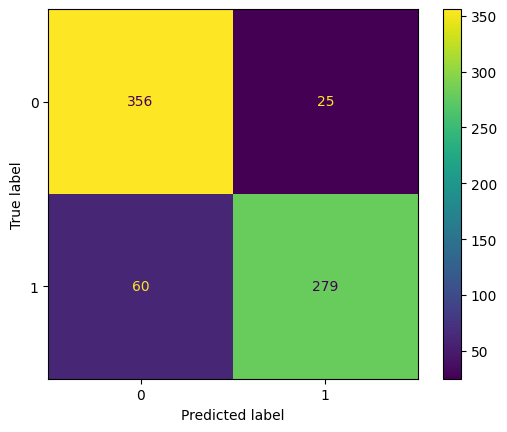

In [63]:
random_forest = RandomForestClassifier(max_depth=30, random_state=42)
random_forest.fit(tfidf_train, y_train)

y_pred_random_forest = random_forest.predict(tfidf_test)
evaluate(y_test, y_pred_random_forest)

In this example:

TP = 279

FP = 25

FN = 60

TN = 356

# Explainable AI (XAI)

After training the model, we want to find out how our model makes its prediction and make sure that it is not doing some random guesses. 

Sometimes the model may even look at the wrong thing!

Would you want a model that predicts whether you have lung infection just by looking at your age, gender and weight? 

I would not want that! It should look at features such as Chest Scan, Sign & Symptoms, etc., those that doctors look at to make their diagnosis!


Explainable AI can help to explain how our models make its prediction so that we can have a understanding of how good our model is.

### Explainable AI Libraries
Here are some libraries for Explainable AI
1. Local Interpretable Model-Agnostic Explanations (LIME): https://github.com/marcotcr/lime
2. Explain Like I'm 5 (ELI-5): https://eli5.readthedocs.io/en/latest/overview.html
3. SHapley Additive exPlanations (SHAP): https://shap.readthedocs.io/en/latest/

In this tutorial, we showcase some examples on how to use SHAP to explain the common classification models, namely Logistic Regression, Decision Trees and Random Forest.

The theory will not be covered, but you may refer the the documentation if you are interested.

Feel free to explore the other libraries if you are interested.

In [64]:
import shap
shap.initjs()

In [65]:
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Explainer for Logistic Regression

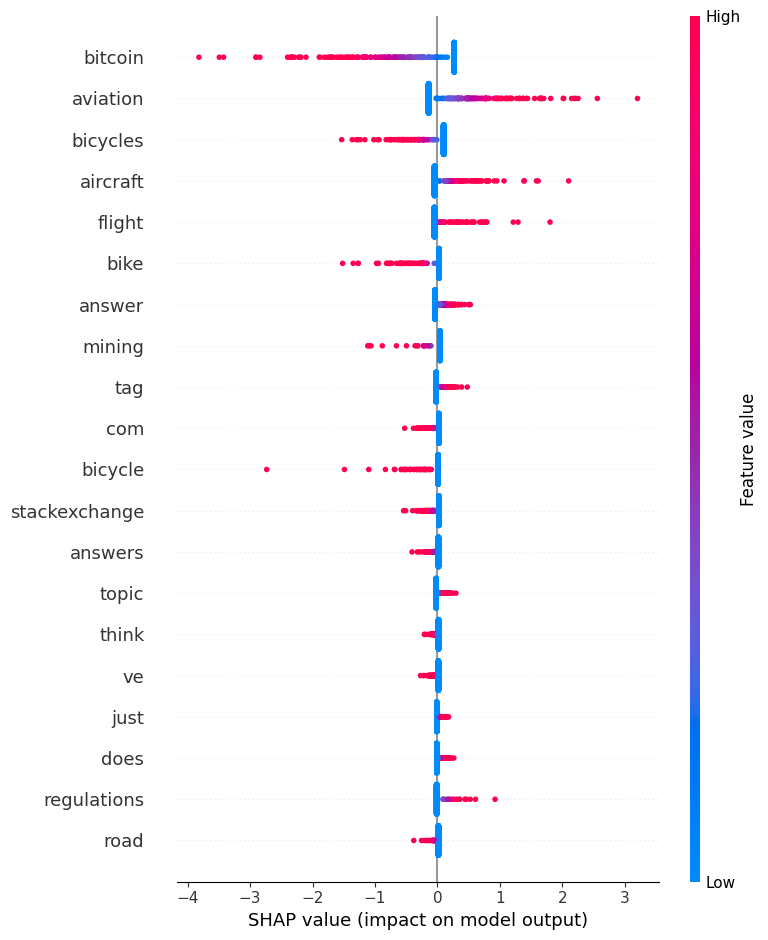

In [66]:
explainer = shap.LinearExplainer(lr, tfidf_train_df)
shap_values = explainer(tfidf_test_df)
shap.summary_plot(shap_values, tfidf_test_df)

### How to interpret this SHAP plot

The color of the dots represents the TF-IDF score (feature value) of the feature in a particular data. Red represents a higher TF-IDF score and while Blue represents lower TF-IDF score.

If there are more red dots on the *right* of the middle line (SHAP value > 0), it represents that higher TF-IDF score of the feature contributes to a *positive* prediction
If there are more red dots on the *left* of the middle line (SHAP value < 0), it represents that higher TF-IDF score of the feature contributes to a *negative* prediction

The absence of the word "bitcoin" and "bicycles" and presence of "aviation" are the top 3 factors that contributes to the model giving a positive prediction.

Let's look at individual examples, in this case index 100:

Text: 
i have asked several questions on stack exchange, but my questions are often not understood. they seem a little too pedantic.  this is an actual question that i wrote on the aviation stack exchange site but could not post due to the 40 minute rule. how can i improve this question? a brief review of light aircraft designs one is struck by the similar
  performance figures of aircraft that have similar wing areas and
  engine horsepower. for example aircraft with a 180 hp engine rarely
  can fly faster than 120 knots if they have fixed gear. with
  retractable gear an increase in 10-15 knots seems reasonable.  stall speeds are proportional to wing area and can be reduced with
  high lift devices such as vortex generators, slats, flaps and so on. how reliable it the process of designing and aircraft based on the
  lift equation for determining the stalling speed and an empirical
  formula for cruising speed as a function of engine power? is using a
  sophisticated design program th

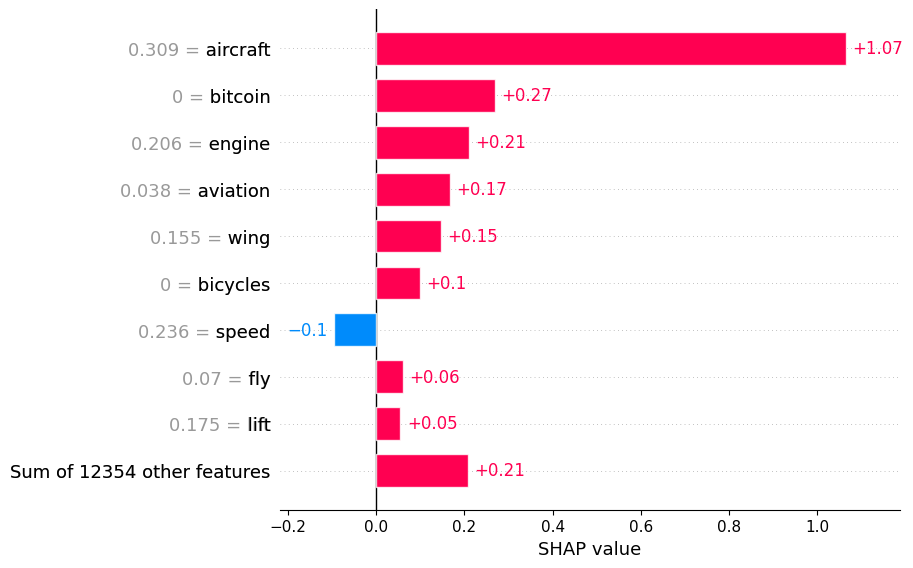

In [67]:
index = 100
print(f"Text: \n=========\n{X_test.iloc[index]}\n=========\n")
print(f"The label is: {y_test.iloc[index]}")
print(f"The prediction is: {y_pred_lr[index]}")

shap_values_ind = explainer(tfidf_test_df.iloc[[index]])
shap.plots.bar(shap_values_ind[0])

The numbers on the left of the "=" sign represents the TF-IDF score.

The presence of "aircraft" and "engine", absence of "bitcoin" (notice that the value is 0) are the top 3 factors that contributes to the model giving a positive prediction.

# Explainer for Decision Tree

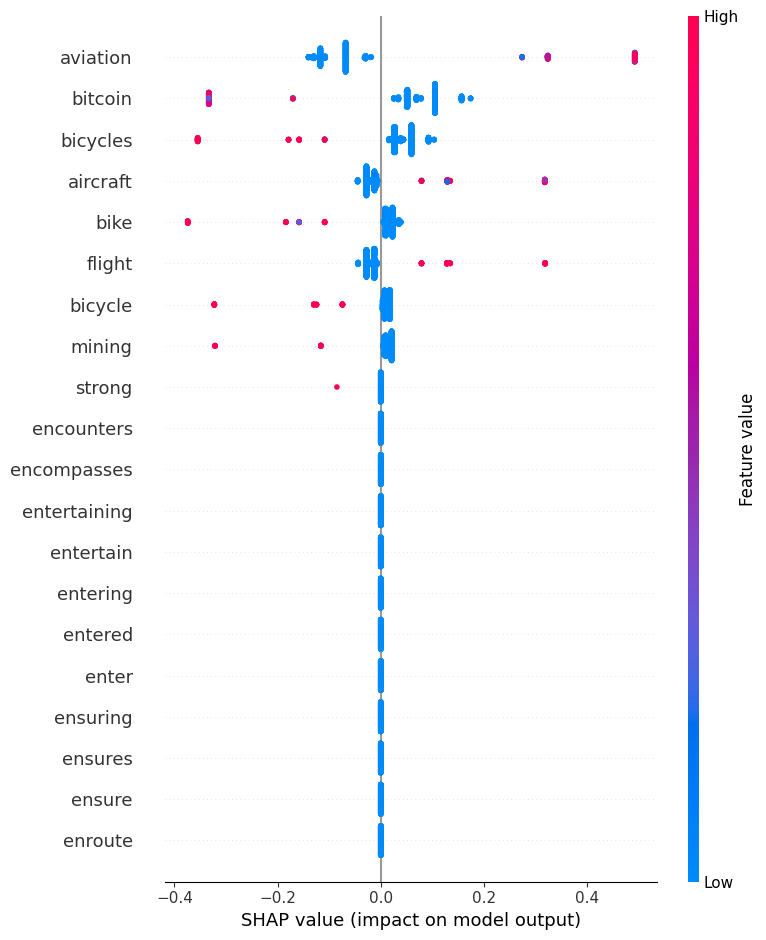

In [68]:
# compute SHAP values
explainer = shap.TreeExplainer(decision_tree, tfidf_train_df)
shap_values = explainer(tfidf_test_df)
shap.summary_plot(shap_values[:,:,1], tfidf_test_df)
# This is not a good SHAP plot, which implies that our model is not good enough.
# Can you retrain this model so that it gives a good SHAP plot?

Text: 
transaction-malleability a property of bitcoin transactions that allows them to be replicated with another transaction id before they are included in a block.

The label is: 0
The prediction is: 0


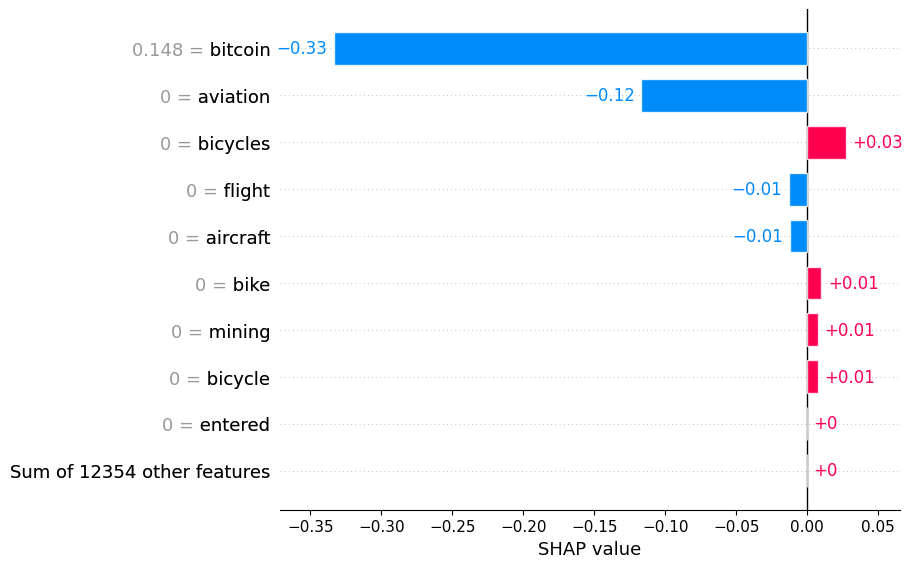

In [69]:
index = 10
print(f"Text: \n=========\n{X_test.iloc[index]}\n=========\n")
print(f"The label is: {y_test.iloc[index]}")
print(f"The prediction is: {y_pred_decision_tree[index]}")

shap_values_ind = explainer(tfidf_test_df.iloc[[index]])
shap.plots.bar(shap_values_ind[:,:,1][0])

The presence of "bitcoin" and the absence of "aviation", "flight" contributed to the prediction of 0. (Note that the absence of "bicycles" contributed to the positive label)

# Explainer for Random Forest

 97%|=================== | 1394/1440 [00:24<00:00]       

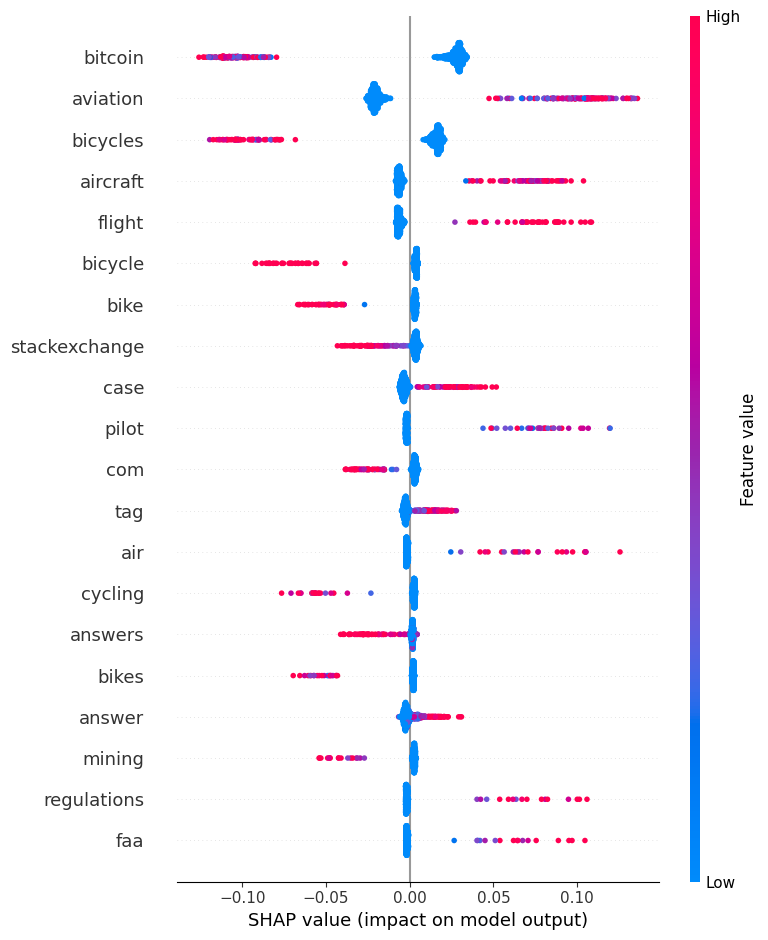

In [70]:
# compute SHAP values
explainer = shap.TreeExplainer(random_forest, tfidf_train_df)
shap_values = explainer(tfidf_test_df)
shap.summary_plot(shap_values[:,:,1], tfidf_test_df)

Text: 
are questions relating to rules or common practices of the tour de france, giro d'italia etc appropriate here?  by that i mean a question that is solely to do with being a fan of the sport as opposed to actually participating in it. i realise a consensus was reached four years ago in this question, however as a commenter noted sports.se has surfaced since then which may (or may not) be more appropriate. tl;dr: should i ask tdf related questions here or on sports.se?

The label is: 0
The prediction is: 1


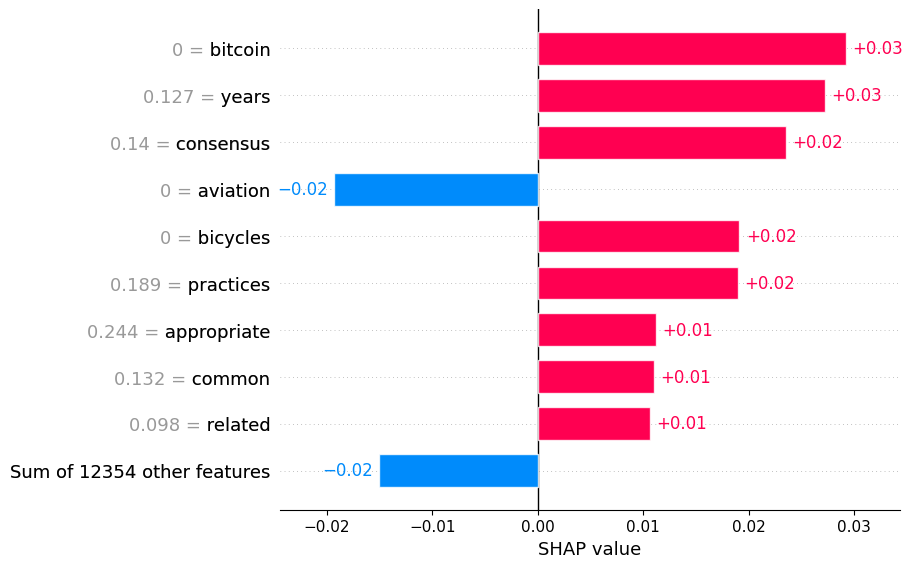

In [71]:
index = 63
print(f"Text: \n=========\n{X_test.iloc[index]}\n=========\n")
print(f"The label is: {y_test.iloc[index]}")
print(f"The prediction is: {y_pred_random_forest[index]}")

shap_values_ind = explainer(tfidf_test_df.iloc[[index]])
shap.plots.bar(shap_values_ind[:,:,1][0])

This example wrongly predicts the text to be related to aviation. Seems that the absence of "bitcoin", presence of "years" and "consensus" plays the biggest factor in the incorrect prediction.

### Conclusion

Hope you have fun playing around with SHAP and looked at how it helps to explain prediction made by models. You may encounter cases where the explaination does not make much sense even though the model has a good performance. Having models with poor explainability may cause users/stakeholders to lose confidence in it, and thus reject it. 

Therefore, it is important to keep model explainability in mind in every data science project.

### Extra exercises (Optional)

1. Apply SHAP on other classification models.
2. Apply SHAP on structured data. Eg. Titanic dataset from Kaggle.
3. (Out of scope) We can also apply Explainable AI on images too! Check out "GradCAM" for more information.

In [ ]:
import hashlib

print('Cyberthon{ai_explained!_' + hashlib.blake2b(b"freeflag").hexdigest()[:16] + '}')